# Downscalling CMIP6 Precipitation Over the Continental United States
##### Here we regrid a CMIP6 dataset to an observational grid. Then we apply a statistical downscalling appraoch.


In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import packages
import xarray as xr
import xesmf as xe
import intake
import util 
import pprint 
import xsd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from dask.distributed import Client
from dask_jobqueue import SLURMCluster 
from xsd.pointwise_models import PointWiseDownscaler, QuantileMapper

## Dask 

In [2]:
# cluster = SLURMCluster(cores=2, memory='12GB', project='UCGD0006')
# cluster.adapt(minimum_cores=0, maximum_cores=30)
# client = Client(cluster)
# cluster = SLURMCluster(cores=36, memory='100GB', project='UCGD0006',
#                        processes=36)
# cluster.adapt(minimum=1*36, maximum=10*36)
from dask.diagnostics import ProgressBar

## Define temporal period of interest

In [3]:
t0 = '1981-01-01'
tf = '1981-12-31'

## Define target grid
##### This is the grid that we will interpolate CMIP6 data to. 

In [4]:
cat = intake.Catalog('/glade/u/home/jhamman/hap_data.yaml')
tgt_ds = cat['gmet_v2'].to_dask()
tgt_ds = tgt_ds.sel(time=slice(t0, tf))
tgt_grid = xr.Dataset({'lat': (['lat'], tgt_ds['lat']),
                     'lon': (['lon'], tgt_ds['lon'])})

## Retrieve CMIP6 data
##### This data will be regridded to the target grid.

In [5]:
# Querry CMIP6 data catalog for desired data
cat = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
cat = cat.search(experiment_id = ['historical'], source_id = ['CESM2'], \
                 table_id = ['day'], variable_id = ['pr'], member_id = ['r2i1p1f1'])
#                  table_id = ['day'], variable_id = ['pr'])
print("We have retrived " + str(len(cat.df)) + " files")

# Create dataset
train_ds = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 1000}})
train_ds = train_ds['CMIP.NCAR.CESM2.historical.day.gn']['pr']
train_ds = train_ds.sel(time=slice(t0, tf))
train_ds = train_ds[0,:,:,:]
# train_ds = train_ds.isel(time=slice(47816, 47816 + 364))
train_ds.data

We have retrived 17 files
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


dask.array<getitem, shape=(365, 192, 288), dtype=float32, chunksize=(365, 192, 288), chunktype=numpy.ndarray>

## Regrid CMIP6 grid to target grid

In [6]:
regridder = xe.Regridder(train_ds, tgt_grid, 'bilinear')
regridder.clean_weight_file()
train_ds = regridder(train_ds)
train_ds.data
with ProgressBar():
    train_ds = train_ds.persist() # Applies regridding (no longer lazy!)

Create weight file: bilinear_192x288_224x464.nc
Remove file bilinear_192x288_224x464.nc
[########################################] | 100% Completed |  2.2s


## Unit Conversions

In [7]:
# # Currently the regirdded data is daily time resolution with units of kg/m^2/sec
# # Multiply by 86400 to transform to mm/day (the same as kg/m^2/day)
train_ds = train_ds * 86400

## Calculate Model Bias.
##### Subtract gridden mean 1980

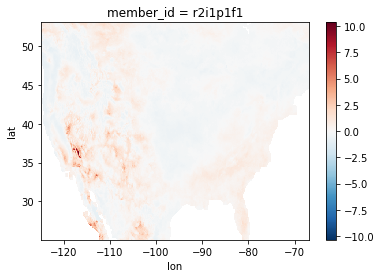

In [8]:
# Calculate model bias
train_mean = train_ds.mean(dim='time')#.mean(dim='member_id')
obs_mean = tgt_ds.mean(dim='time')
train_bias = train_mean - obs_mean['pcp']
train_bias_factor = train_bias / obs_mean['pcp']

# Plot model bias
train_bias_factor.plot.pcolormesh();

## Now apply a linear model statistical downscalling approach using `xsd`

In [12]:
# Temporary hack to make the time dimensions identical. 
train_ds['time']=tgt_ds['time']

# Construct quantile mapping model and then apply on training and target datasets
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

steps = []

steps.append(("standardize", StandardScaler()))
steps.append(("linear regression", LinearRegression()))
pipeline = Pipeline(steps)
qm = PointWiseDownscaler(model=pipeline, dim='time')

qm.fit(train_ds, tgt_ds['pcp'])
predict = qm.predict(train_ds)
predict = predict.compute()

<xarray.DataArray 'pr' (time: 365, lat: 224, lon: 464)>
dask.array<mul, shape=(365, 224, 464), dtype=float64, chunksize=(365, 224, 464), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r2i1p1f1'
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * lon        (lon) float64 -124.9 -124.8 -124.6 -124.5 ... -67.25 -67.12 -67.0
  * lat        (lat) float64 25.12 25.25 25.38 25.5 ... 52.62 52.75 52.88 53.0
[[], ['time']]


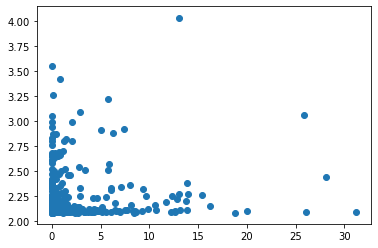

In [24]:
plt.scatter(tgt_ds['pcp'][:, -1, -1], predict[:, -1, -1])